In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33487,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:37211,Total threads: 8
Dashboard: http://127.0.0.1:37933/status,Memory: 62.93 GiB
Nanny: tcp://127.0.0.1:33497,


In [2]:
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset

plt.rcParams['font.size'] = 15

In [19]:
filename_heat = 'diag_heat_budget'
filename_kpp = 'diag_kpp'
filename_mom_u = 'diag_mom_u'
filename_state = 'diag_state'
filename_surf = 'diag_surf'

zMin = -250
zMax = 0
latMin = -0.1
latMax = 0.1

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state,filename_mom_u,filename_surf]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state,filename_mom_u,filename_surf]
ds_vel = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_vel['XC'] = ds.XC.astype(float)
ds_vel['YC'] = ds.YC.astype(float)
ds_vel['Z'] = ds.Z.astype(float)
ds_vel['XG'] = ds.XG.astype(float)
ds_vel['YG'] = ds.YG.astype(float)
ds_vel['Zl'] = ds.Zl.astype(float)

In [20]:
folder_name = '/home/edavenport/analysis/mitgcm-mombudg/velocity_assim/sep2012_UV_compare/'

In [21]:
grid = xgcm.Grid(ds, periodic=['X','Y'])
vol = (ds.rAw*ds.hFacW*ds.drF)
KPP_momU = grid.diff(ds.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU = KPP_momU.where(ds.hFacW.values > 0,0) # set any nan fluxes to 0
ds['Um_Advec'] = ds.Um_Advec - ds.Um_Cori

grid = xgcm.Grid(ds_vel, periodic=['X','Y'])
vol = (ds_vel.rAw*ds_vel.hFacW*ds_vel.drF)
KPP_momU_vel = grid.diff(ds_vel.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU_vel = KPP_momU_vel.where(ds_vel.hFacW.values > 0,0) # set any nan fluxes to 0
ds_vel['Um_Advec'] = ds_vel.Um_Advec - ds_vel.Um_Cori

In [22]:
decorr_scale_days = 5 # see DecorrelationScales_MBTerms.py
N_ind = (90)/decorr_scale_days # approximate number of days in a season
std_err_denom = np.sqrt(N_ind)

In [23]:
lonMin = 165.0
lonMax = 260.0

In [24]:
KPP_momU = KPP_momU.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
Um_Advec = ds.Um_Advec.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
Um_Ext = ds.Um_Ext.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
Um_dPhiX = ds.Um_dPhiX.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
uvel = ds.UVEL.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
vvel = ds.VVEL.sel(Z=slice(zMax,zMin), YG=slice(latMin,latMax),XC=slice(lonMin,lonMax)).squeeze().compute()

KPP_momU_vel = KPP_momU_vel.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
Um_Advec_vel = ds_vel.Um_Advec.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
Um_Ext_vel = ds_vel.Um_Ext.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
Um_dPhiX_vel = ds_vel.Um_dPhiX.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
uvel_vel = ds_vel.UVEL.sel(Z=slice(zMax,zMin), YC=slice(latMin,latMax),XG=slice(lonMin,lonMax)).squeeze().mean(dim='YC').compute()
vvel_vel = ds_vel.VVEL.sel(Z=slice(zMax,zMin), YG=slice(latMin,latMax),XC=slice(lonMin,lonMax)).squeeze().compute()

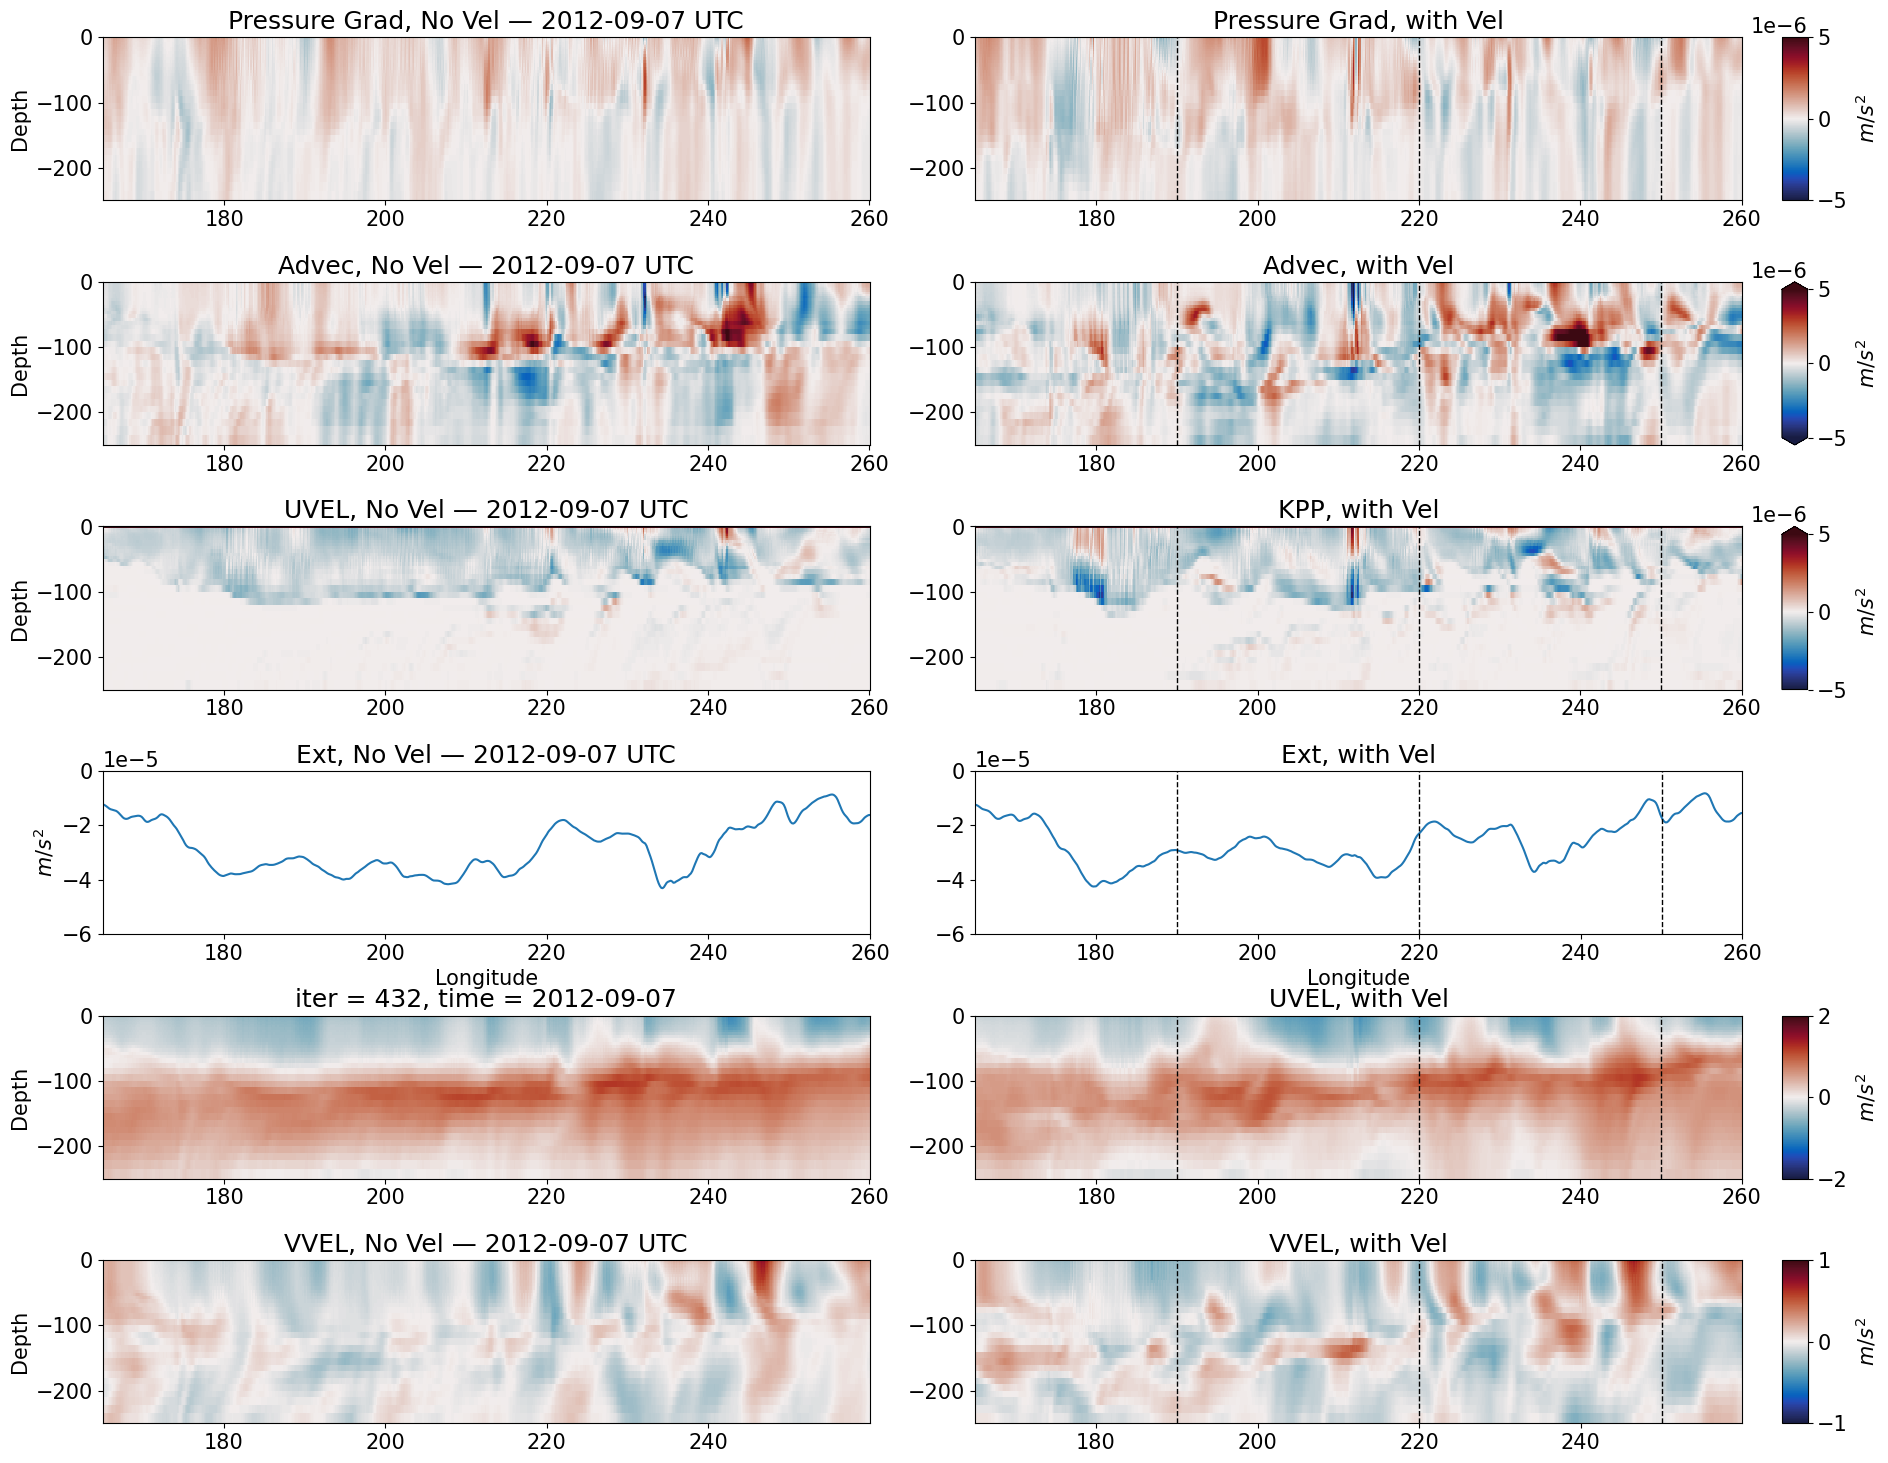

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import pandas as pd
import numpy as np

output_file_mp4 = "momentum_budget_animation.mp4"        # Output video filename
fps = 2

start_frame = 5
vmin = -5e-6
vmax = 5e-6
levels = np.arange(vmin, vmax, 1e-7)

fig = plt.figure(figsize=(22, 18))
# Create a 4-row, 3-column grid: 1st column for plots, 2nd column for colorbars
gs = gridspec.GridSpec(nrows = 6, ncols = 4, width_ratios=[30, 1, 30, 1], height_ratios=[1, 1, 1, 1, 1, 1], wspace=0.1, hspace=0.5)

# --- Row 1 ---
ax0 = fig.add_subplot(gs[0, 0])
# cax0 = fig.add_subplot(gs[0, 1])
dphi = Um_dPhiX.isel(time=start_frame).plot.pcolormesh(ax=ax0, x='XG', y='Z', cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
dphi_title = ax0.set_title('Pressure Grad, No Vel')
ax0.set_xlabel('')
ax0.set_ylabel('Depth')

ax01 = fig.add_subplot(gs[0, 2])
cax01 = fig.add_subplot(gs[0, 3])
phi_vel = Um_dPhiX_vel.isel(time=start_frame).plot.pcolormesh(ax=ax01, x='XG', y='Z', cmap=cmo.balance,
                       cbar_ax=cax01, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax01.set_title('Pressure Grad, with Vel')
ax01.axvline(x=190.0, color='k', linestyle='--', linewidth=1)
ax01.axvline(x=220.0, color='k', linestyle='--', linewidth=1)
ax01.axvline(x=250.0, color='k', linestyle='--', linewidth=1)
ax01.set_xlabel('')
ax01.set_ylabel('')

# --- Row 2 ---
ax1 = fig.add_subplot(gs[1, 0])
# cax1 = fig.add_subplot(gs[1, 1])
advec = Um_Advec.isel(time=start_frame).plot.pcolormesh(ax=ax1, x='XG', y='Z', cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
advec_title = ax1.set_title('Advec, No Vel')
ax1.set_xlabel('')
ax1.set_ylabel('Depth')

ax11 = fig.add_subplot(gs[1, 2])
cax11 = fig.add_subplot(gs[1, 3])
advec_vel = Um_Advec_vel.isel(time=start_frame).plot.pcolormesh(ax=ax11, x='XG', y='Z', cmap=cmo.balance,
                       cbar_ax=cax11, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax11.set_title('Advec, with Vel')
ax11.axvline(x=190.0, color='k', linestyle='--', linewidth=1)
ax11.axvline(x=220.0, color='k', linestyle='--', linewidth=1)
ax11.axvline(x=250.0, color='k', linestyle='--', linewidth=1)
ax11.set_xlabel('')
ax11.set_ylabel('')

# --- Row 3 ---
ax2 = fig.add_subplot(gs[2, 0])
# cax2 = fig.add_subplot(gs[2, 1])
kpp = KPP_momU.isel(time=start_frame).plot.pcolormesh(ax=ax2, x='XG', y='Z', cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
kpp_title = ax2.set_title('KPP, No Vel')
ax2.set_xlabel('')
ax2.set_ylabel('Depth')

ax21 = fig.add_subplot(gs[2, 2])
cax21 = fig.add_subplot(gs[2, 3])
kpp_vel = KPP_momU_vel.isel(time=start_frame).plot.pcolormesh(ax=ax21, x='XG', y='Z', cmap=cmo.balance,
                       cbar_ax=cax21, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax21.set_title('KPP, with Vel')
ax21.axvline(x=190.0, color='k', linestyle='--', linewidth=1)
ax21.axvline(x=220.0, color='k', linestyle='--', linewidth=1)
ax21.axvline(x=250.0, color='k', linestyle='--', linewidth=1)
ax21.set_xlabel('')
ax21.set_ylabel('')

# --- Row 4 (no colorbar, but same width as others) ---
ax3 = fig.add_subplot(gs[3, 0])
ext, = Um_Ext.isel(time=start_frame).isel(Z=0).plot(ax=ax3, x='XG')
ext_title = ax3.set_title('Ext, No Vel')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('$m/s^2$')
ax3.set_ylim(-6e-5,0)
ax3.set_xlim(lonMin,lonMax)

ax31 = fig.add_subplot(gs[3, 2])
ext_vel, = Um_Ext_vel.isel(time=start_frame).isel(Z=0).plot(ax=ax31, x='XG')
ax31.set_title('Ext, with Vel')
ax31.set_xlabel('Longitude')
ax31.axvline(x=190.0, color='k', linestyle='--', linewidth=1)
ax31.axvline(x=220.0, color='k', linestyle='--', linewidth=1)
ax31.axvline(x=250.0, color='k', linestyle='--', linewidth=1)
ax31.set_ylabel('')
ax31.set_ylim(-6e-5,0)
ax31.set_xlim(lonMin,lonMax)

# --- Row 5 ---
vmin = -2.0
vmax = 2.0
ax4 = fig.add_subplot(gs[4, 0])
# cax2 = fig.add_subplot(gs[2, 1])
uvel_pcm = uvel.isel(time=start_frame).plot.pcolormesh(ax=ax4, x='XG', y='Z', cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
uvel_title = ax2.set_title('UVEL, No Vel')
ax4.set_xlabel('')
ax4.set_ylabel('Depth')

ax41 = fig.add_subplot(gs[4, 2])
cax41 = fig.add_subplot(gs[4, 3])
uvel_vel_pcm = uvel_vel.isel(time=start_frame).plot.pcolormesh(ax=ax41, x='XG', y='Z', cmap=cmo.balance,
                       cbar_ax=cax41, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax41.set_title('UVEL, with Vel')
ax41.axvline(x=190.0, color='k', linestyle='--', linewidth=1)
ax41.axvline(x=220.0, color='k', linestyle='--', linewidth=1)
ax41.axvline(x=250.0, color='k', linestyle='--', linewidth=1)
ax41.set_xlabel('')
ax41.set_ylabel('')

# --- Row 5 ---
vmin = -1.0
vmax = 1.0
ax5 = fig.add_subplot(gs[5, 0])
# cax2 = fig.add_subplot(gs[2, 1])
vvel_pcm = vvel.isel(time=start_frame).plot.pcolormesh(ax=ax5, x='XC', y='Z', cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
vvel_title = ax5.set_title('UVEL, No Vel')
ax5.set_xlabel('')
ax5.set_ylabel('Depth')

ax51 = fig.add_subplot(gs[5, 2])
cax51 = fig.add_subplot(gs[5, 3])
vvel_vel_pcm = vvel_vel.isel(time=start_frame).plot.pcolormesh(ax=ax51, x='XC', y='Z', cmap=cmo.balance,
                       cbar_ax=cax51, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax51.set_title('VVEL, with Vel')
ax51.axvline(x=190.0, color='k', linestyle='--', linewidth=1)
ax51.axvline(x=220.0, color='k', linestyle='--', linewidth=1)
ax51.axvline(x=250.0, color='k', linestyle='--', linewidth=1)
ax51.set_xlabel('')
ax51.set_ylabel('')

plt.tight_layout()

# === Animation update function ===
def update(frame):
    frame = frame + start_frame
    dphi.set_array(Um_dPhiX.isel(time=frame).values.ravel())
    phi_vel.set_array(Um_dPhiX_vel.isel(time=frame).values.ravel())
    advec.set_array(Um_Advec.isel(time=frame).values.ravel())
    advec_vel.set_array(Um_Advec_vel.isel(time=frame).values.ravel())
    kpp.set_array(KPP_momU.isel(time=frame).values.ravel())
    kpp_vel.set_array(KPP_momU_vel.isel(time=frame).values.ravel())
    ext.set_ydata(Um_Ext.isel(time=frame).isel(Z=0).values)
    ext_vel.set_ydata(Um_Ext_vel.isel(time=frame).isel(Z=0).values)
    uvel_pcm.set_array(uvel.isel(time=frame).values.ravel())
    uvel_vel_pcm.set_array(uvel_vel.isel(time=frame).values.ravel())
    vvel_pcm.set_array(vvel.isel(time=frame).values.ravel())
    vvel_vel_pcm.set_array(vvel_vel.isel(time=frame).values.ravel())

    time_str = pd.to_datetime(Um_Ext.time[frame].values).strftime("%Y-%m-%d UTC")
    dphi_title.set_text(f"Pressure Grad, No Vel — {time_str}")
    advec_title.set_text(f"Advec, No Vel — {time_str}")
    kpp_title.set_text(f"KPP, No Vel — {time_str}")
    ext_title.set_text(f"Ext, No Vel — {time_str}")
    uvel_title.set_text(f"UVEL, No Vel — {time_str}")
    vvel_title.set_text(f"VVEL, No Vel — {time_str}")
    return [dphi, phi_vel, advec, advec_vel, kpp, kpp_vel, ext, uvel_pcm, uvel_vel_pcm, vvel_pcm, vvel_vel_pcm, ext_vel, dphi_title, advec_title, kpp_title, ext_title, uvel_title, vvel_title]
ani = animation.FuncAnimation(fig, update, frames=(len(Um_Ext.time)-start_frame), blit=False)

# === Save animation as MP4 ===
ani.save(output_file_mp4, fps=fps, writer="ffmpeg", dpi=200)


In [28]:
cluster.close()
client.shutdown()
client.close()